In [1]:
import pandas as pd
import numpy as np
import os
import spacy
from collections import Counter


import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('./data/Result/dataset.csv')

In [3]:
df.head()

,Text,Class
0,"Q. Mr. President, in connection with your anno...",Political speech
1,"Well, that would take more time than I have, b...",Political speech
2,The matter is now pending in the United Nation...,Political speech
3,"Q. Mr. President, sir, I wonder what you think...",Political speech
4,"In the winning of our independence, in the str...",Political speech


In [4]:
# Load the spacy model
nlp = spacy.load("en_core_web_sm")

In [5]:
class_counts = Counter(df['Class'])
class_counts

Counter({'Political speech': 799,
         'News': 1001,
         'Jurisdiction': 780,
         'Literature': 17,
         'Blog': 998})

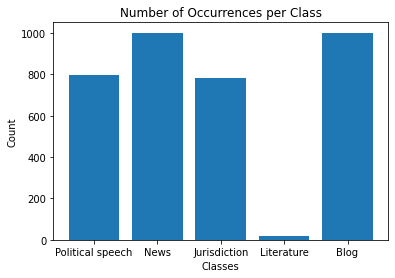

In [6]:
# Show current occurences of the different classes in the dataframe
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Number of Occurrences per Class')
plt.show()

### Balancing the dataset

In [7]:
# Get minimum number of occurences
min_count = min(class_counts.values())

df_balanced = pd.DataFrame()

# Iterate over all classes
for category in class_counts.keys():
    # Get a random sample of the category, so it gets downsampled
    category_subset = df[df['Class'] == category].sample(n=min_count, random_state=42)
    df_balanced = df_balanced.append(category_subset)

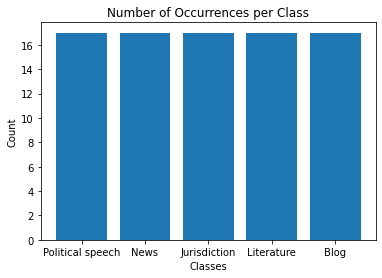

In [8]:
class_counts_balanced = Counter(df_balanced['Class'])

# Show occurences of the different classes in the balanced dataframe
plt.bar(class_counts_balanced.keys(), class_counts_balanced.values())
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Number of Occurrences per Class')
plt.show()

In [9]:
# Dictionary for converting the classes to numeric representation for the usage in the model
classes_mapping = {
    'Literature': 0,
    'News': 1,
    'Blog': 2,
    'Political speech': 3,
    'Jurisdiction': 4
}

df_balanced = df_balanced.replace({"Class": classes_mapping})

In [10]:
# Get texts and classes of dataframe
text = df_balanced.Text.values
classes = df_balanced.Class.values

In [11]:
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    # set number of classes to classes in df['Class']
    num_labels = len(df['Class'].unique()),
    output_attentions = False,
    output_hidden_states = False,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [12]:
token_id = []
attention_masks = []

def preprocessing(text, tokenizer):

  return tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = 128,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
classes = torch.tensor(classes)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [13]:
test_ratio = 0.2

batch_size = 32

# Indices of the train and test splits stratified by labels
train_idx, test_idx = train_test_split(
    np.arange(len(classes)),
    test_size = test_ratio,
    shuffle = True,
    stratify = classes)

# Train and test sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          classes[train_idx])

test_set = TensorDataset(token_id[test_idx], 
                        attention_masks[test_idx], 
                        classes[test_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

test_dataloader = DataLoader(
            test_set,
            sampler = SequentialSampler(test_set),
            batch_size = batch_size
        )

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), 
                              # set learning rate
                              lr = 2e-5,
                            #   eps = 1e-08
                              )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 1

for epoch in range(num_epochs):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    tr_accuracy = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    avg_loss = tr_loss / nb_tr_steps

    # ========== Evaluation ==========

    # Set model to evaluation mode
    model.eval()

    total_correct = 0
    total_samples = 0

    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            eval_output = model(b_input_ids, 
                            token_type_ids = None, 
                            attention_mask = b_input_mask)
            logits = eval_output.logits
            label_ids = b_labels.to('cpu').numpy()
            # Calculate validation metrics

            _, predicted_labels = torch.max(logits, 1)

            total_correct += (predicted_labels == b_labels).sum().item()
            total_samples += b_labels.size(0)

    accuracy = total_correct / total_samples

    print(f"Epoch {epoch+1}:")
    print(f"  Loss: {avg_loss:.4f}")
    print(f"  Test Accuracy: {accuracy:.4f}")

Epoch 1:
  Loss: 1.6027
  Test Accuracy: 0.4706


In [19]:
import pickle
# save the model to disk
filename = './models/finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))